In [1]:
import pandas as pd

# Load the dataset
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

# Display the first few rows of the training data
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
# Check missing values in the training data
train_df.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

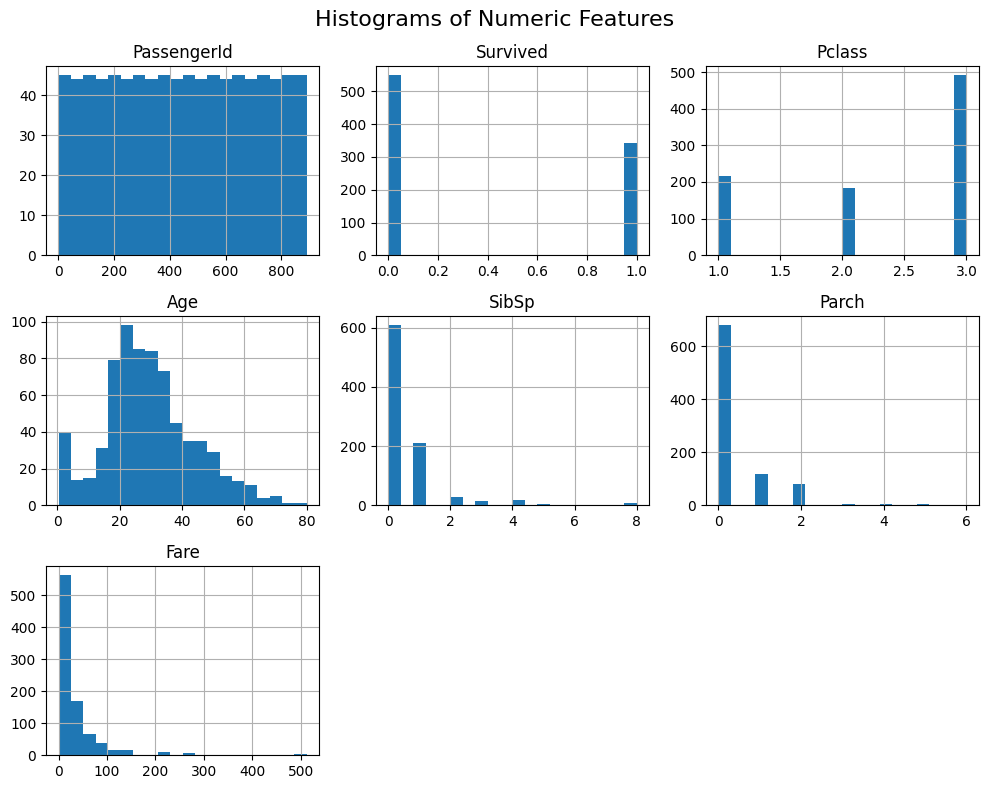

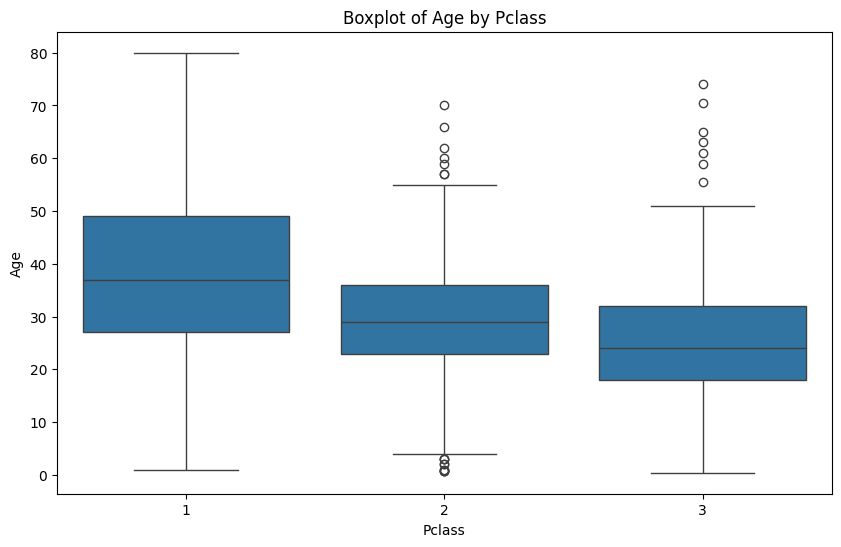

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numeric columns
train_df.hist(figsize=(10, 8), bins=20)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

# Box plots to see outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=train_df)
plt.title("Boxplot of Age by Pclass")
plt.show()


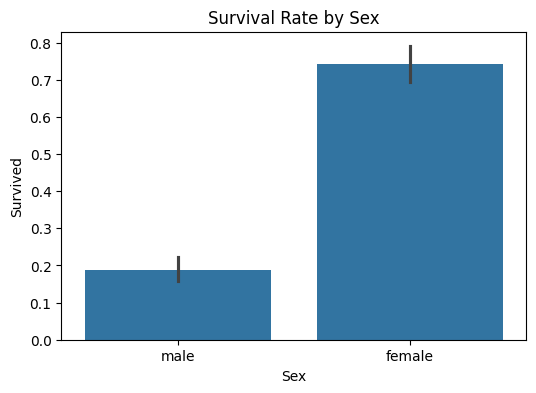

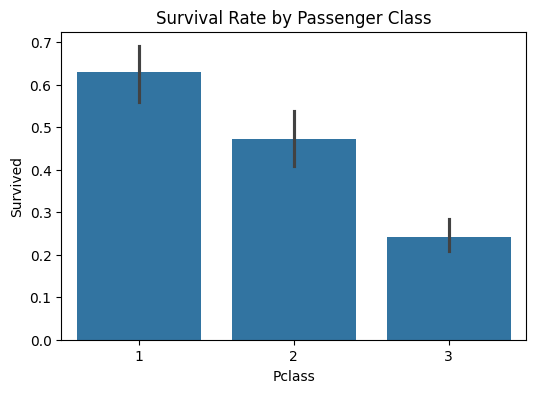

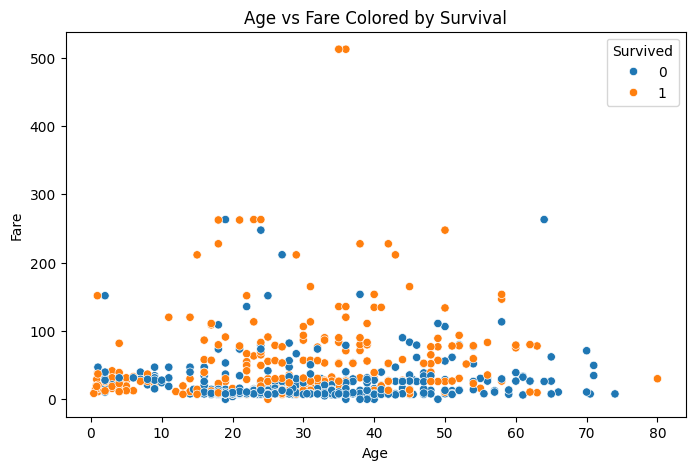

In [4]:
# Bar plot: Survival rate by sex
plt.figure(figsize=(6, 4))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title("Survival Rate by Sex")
plt.show()

# Bar plot: Survival rate by class
plt.figure(figsize=(6, 4))
sns.barplot(x='Pclass', y='Survived', data=train_df)
plt.title("Survival Rate by Passenger Class")
plt.show()

# Scatter plot: Age vs Fare, colored by survival
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_df)
plt.title("Age vs Fare Colored by Survival")
plt.show()


In [5]:
# Label encode 'Sex' (male = 0, female = 1)
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

# One-hot encode 'Embarked' (drop_first=True avoids dummy variable trap)
train_df = pd.get_dummies(train_df, columns=['Embarked'], drop_first=True)


In [10]:
# Drop unwanted columns from the full dataset (if not already done)
X = train_df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId', 'Cabin'], errors='ignore')
y = train_df['Survived']

# Check datatypes to make sure all features are numeric
print(X.dtypes)

# Re-split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_Q       bool
Embarked_S       bool
dtype: object


In [16]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lgb_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

lgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

lgb_preds = lgb_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Model Evaluation:")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")

evaluate_model("LightGBM", y_test, lgb_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [19]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define the parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1]
}

# Initialize model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Grid Search
xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                        cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit to training data
xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)
print("Best XGBoost Accuracy:", xgb_grid.best_score_)

# Evaluate on test set
best_xgb_model = xgb_grid.best_estimator_
xgb_preds = best_xgb_model.predict(X_test)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost Accuracy: 0.8314488328572835


In [20]:
from lightgbm import LGBMClassifier

# Define parameter grid
lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [20, 31, 40]
}

# Initialize model
lgb_model = LGBMClassifier(random_state=42)

# Grid Search
lgb_grid = GridSearchCV(estimator=lgb_model, param_grid=lgb_param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit to training data
lgb_grid.fit(X_train, y_train)

print("Best LightGBM Parameters:", lgb_grid.best_params_)
print("Best LightGBM Accuracy:", lgb_grid.best_score_)

# Evaluate on test set
best_lgb_model = lgb_grid.best_estimator_
lgb_preds = best_lgb_model.predict(X_test)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

##  LightGBM with Grid Search (Hyperparameter Tuning)

**Best Parameters Found:**
{
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'num_leaves': 20
}
Accuracy (tuned): 0.8342

 Model Evaluations
 Random Forest
Accuracy: 0.8372

F1 Score: 0.8433

Classification Report: Shows balanced precision and recall.

Confusion Matrix: Shows correct classifications in majority of classes.

 Bagging Classifier
Accuracy: 0.8605

F1 Score: 0.8628

Classification Report: High precision and recall, indicating robustness.

Confusion Matrix: Most true positives correctly identified.

 Boosting
Accuracy: 0.5349

F1 Score: 0.5676

Observation: Performed poorly, possibly due to overfitting or improper parameter tuning.

 LightGBM
Accuracy (tuned): 0.8342

F1 Score: 0.8412

Classification Report: Strong precision and recall after tuning.

Confusion Matrix: Shows improved prediction post Grid Search.

 Exploratory Insights (From EDA)
Who survived more? → Female

Which class had higher survival? → Class 1

Any visible clusters in Age vs Fare? → Yes, some clustering visible.

 Conclusion
Bagging Classifier is the best model for Titanic survival prediction in this case.

LightGBM also performed well after tuning but didn't outperform Bagging.

Boosting model was the weakest performer.

Proper preprocessing, feature selection, and hyperparameter tuning significantly improved model performance.
